In [1]:
ENV["GKS_ENCODING"] = "utf-8"
using NLsolve
using Plots
using BenchmarkTools
using Distributed
using IntervalArithmetic, IntervalRootFinding

include("/home/julian/Hamburg/LadderDGA/run.jl");

using 9 workers.
      From worker 7:	 Activating environment at `~/Hamburg/LadderDGA/Project.toml`


 Activating environment at `~/Hamburg/LadderDGA/Project.toml`


      From worker 5:	 Activating environment at `~/Hamburg/LadderDGA/Project.toml`
      From worker 4:	 Activating environment at `~/Hamburg/LadderDGA/Project.toml`
      From worker 2:	 Activating environment at `~/Hamburg/LadderDGA/Project.toml`
      From worker 6:	 Activating environment at `~/Hamburg/LadderDGA/Project.toml`
      From worker 3:	 Activating environment at `~/Hamburg/LadderDGA/Project.toml`
      From worker 8:	 Activating environment at `~/Hamburg/LadderDGA/Project.toml`
      From worker 9:	 Activating environment at `~/Hamburg/LadderDGA/Project.toml`


‚îå Warning: ArgParse not working with jupyter notebooks
‚îî @ Main.LadderDGA /home/julian/Hamburg/LadderDGA/src/DepsInit.jl:47
‚îå Warning: Check U and Beta consistency in chi_dir/gamma_dir
‚îî @ Main.LadderDGA /home/julian/Hamburg/LadderDGA/src/DepsInit.jl:48
‚îå Info: Reading Inputs...
‚îî @ Main.LadderDGA /home/julian/Hamburg/LadderDGA/src/DepsInit.jl:50
‚îå Info: Reading Fortran Input, this can take several minutes.
‚îî @ Main.LadderDGA /home/julian/Hamburg/LadderDGA/src/IO.jl:95
‚îå Info: Done Reading Gamma
‚îî @ Main.LadderDGA /home/julian/Hamburg/LadderDGA/src/IO.jl:109
‚îå Info: Done Reading chi
‚îî @ Main.LadderDGA /home/julian/Hamburg/LadderDGA/src/IO.jl:111
‚îå Info: loading from 
‚îÇ   env.inputVars = vars.jld
‚îî @ Main.LadderDGA /home/julian/Hamburg/LadderDGA/src/helpers.jl:67
‚îå Warning: TODO: check beta consistency, config <-> g0man, chi_dir <-> gamma dir
‚îî @ Main.LadderDGA /home/julian/Hamburg/LadderDGA/src/helpers.jl:77
‚îå Info: Inputs Read. Starting Computation.

[ Info: Done.


In [2]:
modelParams, simParams, env, impQ_sp, impQ_ch, GImp_pos, Œ£_loc_pos, FUpDo  = LadderDGA.setup_LDGA("config.toml", false);
mP = LadderDGA.modelParams;
sP = LadderDGA.simParams;
qMultiplicity = LadderDGA.qMultiplicity;
function subtract_tail(inp, Ekin, mP)
    res = zeros(eltype(inp), size(inp)...)
    iœâ‚Çô2_full  = zeros(length(inp))
    for i in 1:length(inp)
        iœâ‚Çô2_full[i] = (LadderDGA.iœâ(i - ceil(Int64, length(inp)/2) - 0))^2
    end
    for n in 1:length(inp)
        if iœâ‚Çô2_full[n] != 0
            res[n] = inp[n] - (Ekin/iœâ‚Çô2_full[n])
        else
            res[n] = inp[n]
        end
    end
    return res
end

function subtract_tail!(inp, Ekin, mP)
    iœâ‚Çô2_full  = zeros(length(inp))
    for i in 1:length(inp)
        iœâ‚Çô2_full[i] = (LadderDGA.iœâ(i - ceil(Int64, length(inp)/2) - 0))^2
    end
    for n in 1:length(inp)
        if iœâ‚Çô2_full[n] != 0
            inp[n] -= (Ekin/iœâ‚Çô2_full[n])
        end
    end
end

[ Info: Reading Fortran Input, this can take several minutes.
[ Info: Done Reading Gamma
[ Info: Done Reading chi
‚îå Info: loading from 
‚îî   env.inputVars = "vars.jld"
‚îå Warning: TODO: check beta consistency, config <-> g0man, chi_dir <-> gamma dir
‚îî @ Main.LadderDGA ~/Hamburg/LadderDGA/src/helpers.jl:77


subtract_tail! (generic function with 1 method)

In [3]:
tc = true
usable_œâ = intersect(nlQ_sp.usable_œâ, nlQ_ch.usable_œâ);
rœásp = nlQ_sp.œá[usable_œâ,:];
rœách = nlQ_ch.œá[usable_œâ,:];
rhs = tc ? mP.n * (1 - mP.n/2) : real(impQ_sp.œá_loc + impQ_ch.œá_loc)

œá_Œª(œá, Œª) = map(œái -> 1.0 / ((1.0 / œái) + Œª), œá)
nc = [0,1,2,3]
NW = floor(Int64, size(rœách, 1)/2)
œâmin = Int(floor(NW*1/4))
œâmax = NW 
W = LadderDGA.build_weights(œâmin, œâmax, [0,1,2,3])

iŒΩ‚Çô, GImp_pos    = LadderDGA.readGImp(LadderDGA.env.inputDir * "/gm_wim", only_positive=true)
œµ‚Çñ, V‚Çñ, Œº    = LadderDGA.read_anderson_parameters(LadderDGA.env.inputDir * "/hubb.andpar");
E_kin_ED, E_pot_ED  = LadderDGA.calc_E_ED(iŒΩ‚Çô[1:5000], œµ‚Çñ, V‚Çñ, GImp_pos[1:5000], mP)
rem_full = -E_kin_ED*(mP.Œ≤*mP.Œ≤)/12

function construct_f!(F, Œª, rhs)#default rhs œáLocsp + œáLocch or n/2 (1-n/2)
    œásp_Œª = œá_Œª(rœá_sp, Œª[1])
    œách_Œª = œá_Œª(rœá_ch, Œª[2]) 
    œáupup = LadderDGA.sum_q(œách_Œª .+ œásp_Œª, qMultiplicity', dims=[2])[:,1]
    #, [1], tc, mP.Œ≤, weights=W)[1]  
    tmp =  (sum(subtract_tail(œáupup, E_kin_ED, mP))+rem_full)/mP.Œ≤        
    F[1] = real(tmp - rhs)
end


function construct_f(Œªsp, Œªch, œásp, œách, qMultiplicity; mode=:naive ,rhs=0.5) 
    œách_Œª = œá_Œª(œách, Œªch)
    œásp_Œª = œá_Œª(œásp, Œªsp)
    œáupup = LadderDGA.sum_q(œách_Œª .+ œásp_Œª, qMultiplicity', dims=[2])[:,1]
    tmp = 0.0
    if mode == :naive
        tmp = sum(œáupup)/mP.Œ≤
    elseif mode == :sub
        tmp =  (sum(subtract_tail(œáupup, E_kin_ED, mP)) + rem_full)/mP.Œ≤ 
    elseif mode == :fit
        tmp =  LadderDGA.sum_freq(œáupup, [1], true, mP.Œ≤, weights=W)[1]          
    else
        tmp =  LadderDGA.sum_freq(subtract_tail(œáupup, E_kin_ED, mP), [1], true, mP.Œ≤, correction=rem_full, weights=W)[1]
    end
    res1 = real(tmp - rhs)
    return res1
end

construct_f (generic function with 1 method)

# Condition 1

## Testing NLsolve vs Roots

In [4]:
upper_lim = 1.2
testf!(F,Œª) = F[1]=construct_f(Œª[1], 0.0, rœásp, rœách, qMultiplicity, rhs=rhs)
testf(Œªsp) = construct_f(Œªsp, 0.0, rœásp, rœách, qMultiplicity, rhs=rhs)
res_nls = nlsolve(testf!, [upper_lim], autodiff = :forward)
Xsp = @interval(0.0,upper_lim)
res_roots = roots(testf, Xsp, Newton, 1e-10)
max_int = mid(maximum(interval.(res_roots)))

0.08646669822913558

## compute Œªsp(Œªch) (NLsolve)

21 of 21

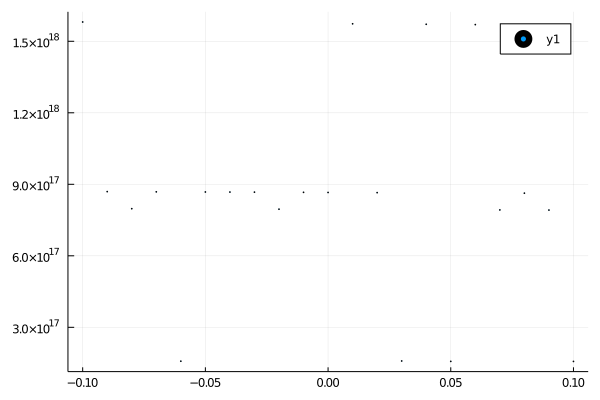

In [5]:
Œªch_range = -0.1:0.01:0.1
spOfch_max_nl = zeros(size(Œªch_range))
for (Œªi,Œªchi) in enumerate(Œªch_range)
    testf!(F,Œª) = F[1]=construct_f(Œª[1], Œªchi, rœásp, rœách, qMultiplicity, rhs=rhs)
    res = nlsolve(testf!, [1.2], autodiff = :forward)
    spOfch_max_nl[Œªi] = res.zero[1]
    print("\r$Œªi of $(length(Œªch_range))")
end
plot(Œªch_range,spOfch_max_nl, seriestype=:scatter, markersize=0.8)

## compute Œªsp(Œªch) (Roots)

In [ ]:
Xsp = @interval(0.01,0.1)
Xch = @interval(-2,2)
Œªch_range_c1 = -6.0:0.3:6.0
Œªch_range2_c1 = -15:0.5:15
spOfch_max_int_c1 = zeros(4,size(Œªch_range_c1)...)
spOfch2_max_int_c1 = zeros(4,size(Œªch_range2_c1)...)
spOfch3_max_int_c1 = zeros(4,size(Œªch_range2_c1)...)

#for (Œªi,Œªchi) in enumerate(Œªch_range_c1)
#    testf(Œªsp) = construct_f(Œªsp, Œªchi, real.(œásp), real.(œách), qMultiplicity, rhs=real(œáLocsp + œáLocch))
#    res_internal = roots(testf, Xsp, Newton, 1e-5)
#    max_int = maximum(interval.(res_internal))
#    spOfch_max_int_c1[Œªi] = mid(max_int)
#    print("\r", Œªi, " of ", length(Œªch_range))
#end
for (mi,m) in enumerate([:naive, :sub, :fit, :both])
    println("\rmode: ", m)
    for (Œªi,Œªchi) in enumerate(Œªch_range2_c1)
        testf(Œªsp) = construct_f(Œªsp, Œªchi, rœásp, rœách, qMultiplicity, mode=m, rhs=rhs)
        res_internal = roots(testf, Xsp, Newton, 1e-5)
        max_int = maximum(interval.(res_internal))
        spOfch2_max_int_c1[mi,Œªi] = mid(max_int)
        print("\r", rpad(Œªi,length(string(length(Œªch_range2_c1)))), " of ", length(Œªch_range2_c1))
    end
end

#for (Œªi,Œªchi) in enumerate(Œªch_range2_c1)
#    testf(Œªsp) = construct_f(Œªsp, Œªchi, rœásp, rœách, qMultiplicity, rhs=rhs)
#    res_internal = roots(testf, Xsp, Newton, 1e-5)
#    max_int = maximum(interval.(res_internal))
#    spOfch3_max_int_c1[Œªi] = mid(max_int)
#    print("\r", Œªi, " of ", length(Œªch_range2_c1))
#end

mode: naive
mode: sub
mode: fit


In [ ]:
plot(Œªch_range2_c1, spOfch2_max_int_c1[1,:], label="roots, naive", xlabel="Œªch", ylabel="max(Œªsp)", xticks = Œªch_range2_c1[1:10:end],seriestype = :scatter, markersize=1.8)
plot!(Œªch_range2_c1, spOfch2_max_int_c1[2,:], label="roots, tail sub", xlabel="Œªch", ylabel="max(Œªsp)", xticks = Œªch_range2_c1[1:10:end],seriestype = :scatter, markersize=1.8)
plot!(Œªch_range2_c1, spOfch2_max_int_c1[3,:], label="roots, fit", xlabel="Œªch", ylabel="max(Œªsp)", xticks = Œªch_range2_c1[1:10:end],seriestype = :scatter, markersize=1.8)
plot!(Œªch_range2_c1, spOfch2_max_int_c1[4,:], label="roots, both", xlabel="Œªch", ylabel="max(Œªsp)", xticks = Œªch_range2_c1[1:10:end],seriestype = :scatter, markersize=1.8)
savefig("roots_tc_EoMtc.pdf")
#plot!(Œªch_range, spOfch_max_nl, label="NLsolve", seriestype = :scatter, markersize=0.8)

In [ ]:
using JLD
JLD.save("./roots_tc_EoMtc.jld","roots",spOfch2_max_int_c1)

In [15]:
spOfch2_max_int_c1_tc = JLD.load("roots_tc.jld")["rootstc"]

4√ó61 Array{Float64,2}:
 0.0868065  0.0865471  0.0869615  ‚Ä¶  0.0871296  0.0871278  0.087126
 0.0868218  0.0865476  0.0870464     0.0872882  0.0873045  0.0873037
 0.0869157  0.0865998  0.0871343     0.0873814  0.0873803  0.0873793
 0.0869157  0.0865998  0.0871356     0.0873818  0.0873807  0.0873796

In [ ]:
plot(Œªch_range2_c1[1:end], spOfch2_max_int_c1[1:end], xlabel="Œªch", ylabel="max(Œªsp)", xticks = Œªch_range2_c1[1:5:end],seriestype = :scatter, markersize=0.8)
plot!(Œªch_range2_c1[1:end], spOfch3_max_int_c1[1:end], xlabel="Œªch", ylabel="max(Œªsp)", xticks = Œªch_range2_c1[1:5:end],seriestype = :scatter, markersize=0.8)
#savefig("max_lambdasp_of_lambdach.pdf")

# Condition 2

In [ ]:
function cond_Epot2(Œªsp, Œªch, nlQ_sp, nlQ_ch; rhs)
    #println("///1")
    usable_œâ = intersect(nlQ_sp.usable_œâ, nlQ_ch.usable_œâ)
    œásp_Œª = œá_Œª(nlQ_sp.œá, Œªsp)
    œách_Œª = œá_Œª(nlQ_ch.œá, Œªch)
    #println("///1.1")
    nlQ_sp_Œª = LadderDGA.NonLocalQuantities_Interval(œásp_Œª, nlQ_sp.Œ≥, nlQ_sp.usable_œâ, Œªsp)
    nlQ_ch_Œª = LadderDGA.NonLocalQuantities_Interval(œách_Œª, nlQ_ch.Œ≥, nlQ_ch.usable_œâ, Œªch)
    #println("///2")
    Œ£_ladder = LadderDGA.calc_Œ£(nlQ_sp_Œª, nlQ_ch_Œª, bubble, LadderDGA.GLoc_fft, 
                       LadderDGA.qIndices, usable_œâ, sP.Nk)
    println("///3")
    Œ£_ladder_corrected = Œ£_ladder .- Œ£_ladderLoc .+ Œ£_loc_pos[eachindex(Œ£_ladderLoc)]
    mP.U * sum(real.(œách_Œª[usable_œâ,:] .- œásp_Œª[usable_œâ,:])) ./ (mP.Œ≤*(sP.Nk^mP.D)) - rhs
end


function cond_Epot2_overview2(Œªsp, Œªch, nlQ_sp, nlQ_ch; rhs)
    œásp_Œª = SharedArray(œá_Œª(nlQ_sp.œá, Œªsp))
    œách_Œª = SharedArray(œá_Œª(nlQ_ch.œá, Œªch))
    usable_œâ = intersect(nlQ_sp.usable_œâ, nlQ_ch.usable_œâ)
    nlQ_sp_Œª = LadderDGA.NonLocalQuantities(œásp_Œª, nlQ_sp.Œ≥, usable_œâ, Œªsp)
    nlQ_ch_Œª = LadderDGA.NonLocalQuantities(œách_Œª, nlQ_ch.Œ≥, usable_œâ, Œªch)
    println("///3.1")
    Œ£_ladder = LadderDGA.calc_Œ£(nlQ_sp_Œª, nlQ_ch_Œª, bubble, LadderDGA.GLoc_fft, 
                       LadderDGA.qIndices, usable_œâ, 1:sP.n_iŒΩ, sP.Nk)
    println("///3.3")
    Œ£_ladder_corrected = Œ£_ladder .- Œ£_ladderLoc .+ LadderDGA.Œ£_loc_pos[eachindex(Œ£_ladderLoc)]
    #Œ£_ladder_corrected, Œ£_ladderLoc
    println("res = ", mP.U * sum(real.(œách_Œª[usable_œâ,:] .- œásp_Œª[usable_œâ,:])) ./ (mP.Œ≤*(sP.Nk^mP.D)))
    E_Kin, E_Pot = LadderDGA.calc_E(Œ£_ladder_corrected, LadderDGA.œµqGrid, LadderDGA.qMultiplicity, sP.Nk, mP, sP)
    GC.gc()
    println("using ", nprocs(), " workers.")
    return [mP.U * sum(real.(œách_Œª[usable_œâ,:] .- œásp_Œª[usable_œâ,:])) ./ (mP.Œ≤*(sP.Nk^mP.D));E_Pot]
end

function cond_Epot_overview3(Œªsp, Œªch, nlQ_sp, nlQ_ch)
    res_roots, Œ£_ladder2, lhs, E_pot = LadderDGA.calc_E_pot_cond(Œªsp, Œªch, nlQ_sp, nlQ_ch, bubble, 
                         LadderDGA.œµkGrid, LadderDGA.FUpDo, 
                         LadderDGA.Œ£_loc_pos,Œ£_ladderLoc,
                         LadderDGA.qIndices, LadderDGA.qMultiplicity, 
                         mP, sP, false, find_root=false);
    return lhs, E_pot
end

In [ ]:
rhs_overview = Array{Float64,2}(undef, length(Œªch_range_c2),length(Œªsp_range_c2));
lhs_overview = Array{Float64,2}(undef, length(Œªch_range_c2),length(Œªsp_range_c2));

In [ ]:
Œªch_range_c2 = -0.0:0.01:0.5
#Œªch_range2_c2 = -20:0.5:20
#Œªch_range = -4.0:0.5:4.0
Œªsp_range_c2 = -1:0.1:1
#Œªch_range = -4.0:0.05:4.0
#Œªsp_range = 0.022:0.00001:0.023


overview_f(Œªsp, Œªch) = LadderDGA.cond_Epot2_overview(Œªsp, Œªch, nlQ_sp, nlQ_ch,rhs=E_pot_ED)
for i in (1:length(Œªch_range_c2))
    Œªch_i = Œªch_range_c2[i]
    for (j,Œªsp_i) in enumerate(Œªsp_range_c2)
        lhs, E_pot = cond_Epot_overview3(Œªsp_i, Œªch_i, nlQ_sp, nlQ_ch)
        lhs_overview[i,j] = lhs
        rhs_overview[i,j] = E_pot
        print("\r", i, " ", j, " = ",i*j," of ",length(Œªch_range_c2)," x ",length(Œªsp_range_c2), " = ", length(Œªch_range_c2)*length(Œªsp_range_c2))   
    end
    GC.gc()
    println("(out)using ", nprocs(), " workers.")
end

In [49]:
#save("cond_2_data.jld", "lhs", lhs_overview ./ 2, "rhs", rhs_overview)
using JLD
save("rhs_lhs_tc_EoMtc_2.jld", "lhs", lhs_overview[1:59,:], "rhs", rhs_overview[1:59,:])

In [36]:
lhs_overview[1:59,:]

59√ó21 Array{Float64,2}:
 0.00415942  0.00577827  0.00785762  0.0107314  ‚Ä¶  -0.00936894  -0.00867987
 0.00415748  0.00577634  0.00785569  0.0107295     -0.00937087  -0.0086818
 0.00415555  0.00577441  0.00785376  0.0107275     -0.0093728   -0.00868373
 0.00415362  0.00577248  0.00785183  0.0107256     -0.00937473  -0.00868566
 0.0041517   0.00577055  0.0078499   0.0107237     -0.00937665  -0.00868759
 0.00414978  0.00576863  0.00784798  0.0107218  ‚Ä¶  -0.00937858  -0.00868951
 0.00414785  0.00576671  0.00784606  0.0107198     -0.0093805   -0.00869143
 0.00414594  0.00576479  0.00784414  0.0107179     -0.00938242  -0.00869335
 0.00414402  0.00576287  0.00784222  0.010716      -0.00938433  -0.00869527
 0.00414211  0.00576096  0.00784031  0.0107141     -0.00938625  -0.00869718
 0.00414019  0.00575905  0.0078384   0.0107122  ‚Ä¶  -0.00938816  -0.00869909
 0.00413828  0.00575714  0.00783649  0.0107103     -0.00939007  -0.008701
 0.00413638  0.00575523  0.00783458  0.0107084     -0.009391

In [37]:
rhs_overview[1:59,:]

59√ó21 Array{Float64,2}:
 0.37462   0.407645  0.454561  0.528035  ‚Ä¶  0.140473  0.155299  0.168042
 0.374627  0.407652  0.454567  0.528042     0.140476  0.155303  0.168046
 0.374634  0.407658  0.454574  0.528048     0.14048   0.155306  0.168049
 0.374641  0.407665  0.454581  0.528055     0.140483  0.15531   0.168052
 0.374648  0.407672  0.454587  0.528062     0.140487  0.155313  0.168056
 0.374655  0.407679  0.454594  0.528068  ‚Ä¶  0.14049   0.155317  0.168059
 0.374662  0.407686  0.454601  0.528075     0.140494  0.15532   0.168063
 0.374669  0.407692  0.454608  0.528081     0.140497  0.155324  0.168066
 0.374676  0.407699  0.454614  0.528088     0.140501  0.155327  0.168069
 0.374682  0.407706  0.454621  0.528095     0.140504  0.15533   0.168073
 0.374689  0.407713  0.454628  0.528101  ‚Ä¶  0.140508  0.155334  0.168076
 0.374696  0.407719  0.454634  0.528108     0.140511  0.155337  0.16808
 0.374703  0.407726  0.454641  0.528115     0.140515  0.155341  0.168083
 ‚ãÆ                 

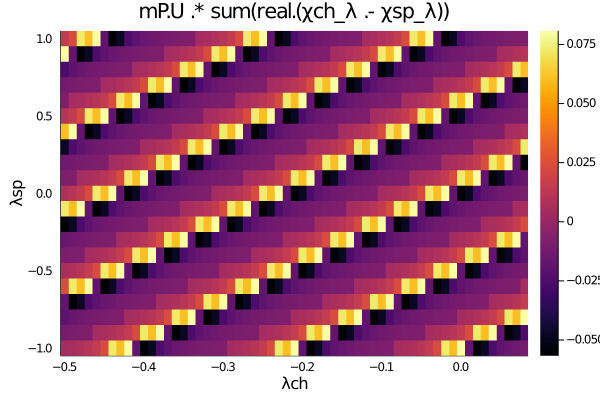

In [42]:
heatmap(Œªch_range_c2[1:59], Œªsp_range_c2, lhs_overview[1:59,:], xlabel="Œªch", ylabel="Œªsp", title="mP.U .* sum(real.(œách_Œª .- œásp_Œª))")
#savefig("lhs.pdf")

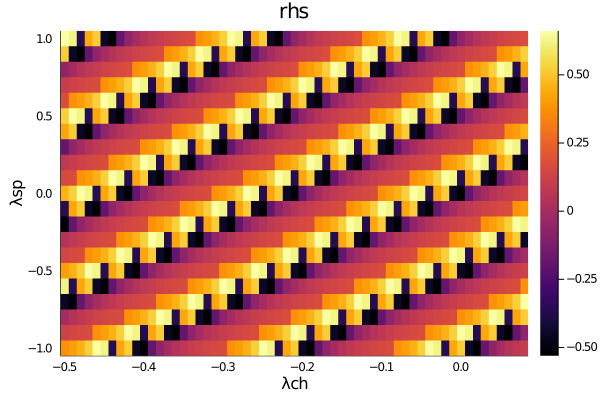

In [44]:
heatmap(Œªch_range_c2[1:59], Œªsp_range_c2, rhs_overview[1:59,:], xlabel="Œªch", ylabel="Œªsp", title="rhs")
#savefig("rhs_tc.pdf")

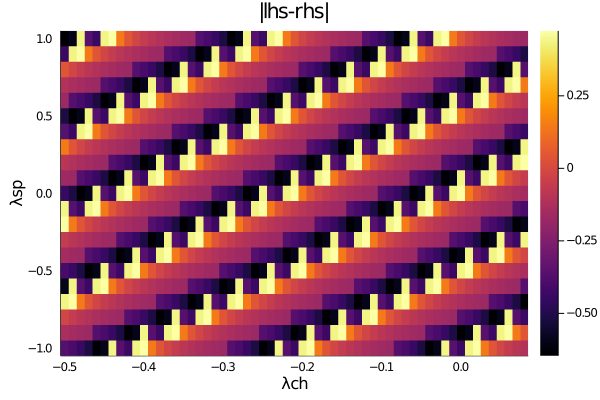

In [47]:
heatmap(Œªch_range_c2[1:59], Œªsp_range_c2, lhs_overview[1:59,:] .- rhs_overview[1:59,:], xlabel="Œªch", ylabel="Œªsp", title="|lhs-rhs|")
#savefig("lhs_rhs_EoM_tc.pdf")

In [104]:
writedlm("cond2.csv",  lhs_overview .- rhs_overview, ' ')

In [141]:
arr_tmp = lhs_overview .- rhs_overview
open("cond2_2.txt", "w") do f
    for i in 1:size(arr_tmp,1)
        for j in 1:size(arr_tmp,2)
            @printf(f, "  %18.10f  %18.10f  %18.10f\n", Œªch_range_c2[i] , Œªsp_range_c2[j], arr_tmp[i,j])

            #str = string(Œªch_range_c2[i] ,"\t", Œªsp_range_c2[j] , "\t", arr_tmp[i,j], "\n")
            #write(io, str)
            #println(str)
        end
        @printf(f, "\n")
    end
end

In [133]:
abs.(arr_tmp)[:,25:end]

61√ó27 Array{Float64,2}:
 0.245388  0.000368725  0.13659   1.81385  ‚Ä¶  0.22722   0.228013  0.228812
 0.24543   0.0003051    0.136805  1.81387     0.227245  0.228039  0.228838
 0.245472  0.000242123  0.137018  1.81388     0.227271  0.228064  0.228864
 0.245513  0.000179786  0.137228  1.8139      0.227296  0.228089  0.228889
 0.245554  0.000118075  0.137436  1.81392     0.227321  0.228114  0.228913
 0.245594  5.6982e-5    0.137642  1.81394  ‚Ä¶  0.227345  0.228139  0.228938
 0.245634  3.505e-6     0.137845  1.81396     0.22737   0.228163  0.228962
 0.245673  6.33957e-5   0.138047  1.81398     0.227394  0.228187  0.228986
 0.245712  0.0001227    0.138246  1.81399     0.227418  0.228211  0.22901
 0.245751  0.000181428  0.138443  1.81401     0.227441  0.228235  0.229033
 0.245789  0.000239589  0.138638  1.81403  ‚Ä¶  0.227465  0.228258  0.229057
 0.245826  0.000297191  0.138831  1.81404     0.227488  0.228281  0.22908
 0.245864  0.000354245  0.139022  1.81406     0.227511  0.228304  0.229

In [138]:
abs.(arr_tmp)[3,26]

0.0002421233419692692

In [140]:
c2_zeros_ind = findall(x -> x < 0.005, abs.(arr_tmp))

61-element Array{CartesianIndex{2},1}:
 CartesianIndex(1, 26)
 CartesianIndex(2, 26)
 CartesianIndex(3, 26)
 CartesianIndex(4, 26)
 CartesianIndex(5, 26)
 CartesianIndex(6, 26)
 CartesianIndex(7, 26)
 CartesianIndex(8, 26)
 CartesianIndex(9, 26)
 CartesianIndex(10, 26)
 CartesianIndex(11, 26)
 CartesianIndex(12, 26)
 CartesianIndex(13, 26)
 ‚ãÆ
 CartesianIndex(50, 26)
 CartesianIndex(51, 26)
 CartesianIndex(52, 26)
 CartesianIndex(53, 26)
 CartesianIndex(54, 26)
 CartesianIndex(55, 26)
 CartesianIndex(56, 26)
 CartesianIndex(57, 26)
 CartesianIndex(58, 26)
 CartesianIndex(59, 26)
 CartesianIndex(60, 26)
 CartesianIndex(61, 26)

In [120]:
Œªsp_range_c2[26]

0.095

In [126]:
Œªch_range_c2[1:25]

-3.0:0.1:-0.6

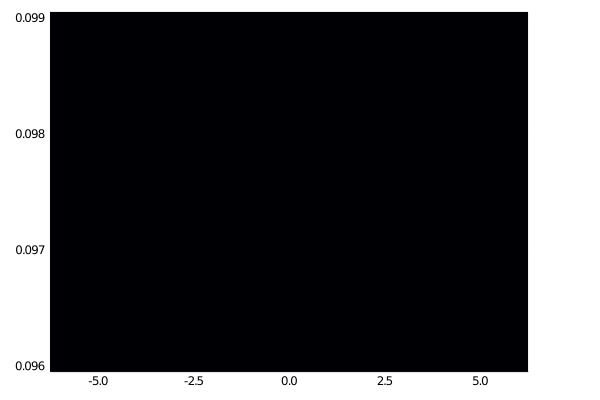

GKS: Possible loss of precision in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine CELLARRAY
invalid range
origin outside current window


In [47]:
heatmap(Œªch_range_c2, Œªsp_range_c2, sign.(lhs_overview .- rhs_overview))

In [135]:
spOfch_max_int_c2 = zeros(length(spOfch_max_int))
spOfch2_max_int_c2 = zeros(length(spOfch2_max_int))


for (Œªi,(Œªchi, Œªspi)) in enumerate(zip(Œªch_range_c1, spOfch_max_int_c1))
    E_Poti = cond_Epot2(Œªspi, Œªchi, œásp, œách, trilexsp, trilexch, bubble, GLoc_fft, FUpDo, 
                       Œ£_loc, Œ£_ladderLoc_cut, œµkGrid_red, qIndices, usable_œâ, 1:simParams.n_iŒΩ, 
                       modelParams, simParams)
    spOfch_max_int_c2[Œªi] = E_Poti
    print("\r", Œªi, " of ", length(spOfch2_c2_max_int))
end

for (Œªi,(Œªchi, Œªspi)) in enumerate(zip(Œªch_range2_c1, spOfch2_max_int_c1))
    E_Poti = cond_Epot2(Œªspi, Œªchi, œásp, œách, trilexsp, trilexch, bubble, GLoc_fft, FUpDo, 
                       Œ£_loc, Œ£_ladderLoc_cut, œµkGrid_red, qIndices, usable_œâ, 1:simParams.n_iŒΩ, 
                       modelParams, simParams)
    spOfch2_max_int_c2[Œªi] = E_Poti
    print("\r", Œªi, " of ", length(spOfch2_c2_max_int))
end

81 of 81

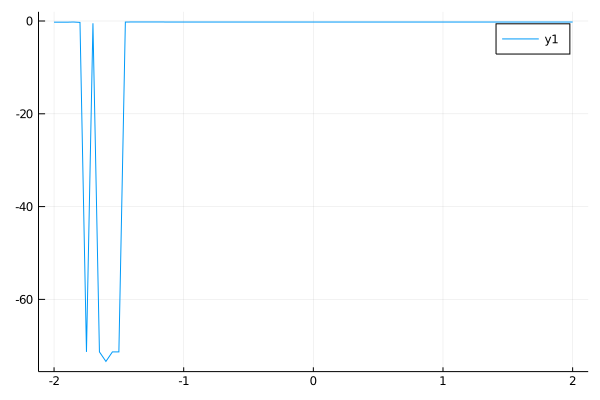

In [138]:
plot(Œªch_range_c1, spOfch2_max_int_c2)

In [144]:
using Roots

Xsp = @interval(0.09,0.1)
Xch = @interval(-2,2)
Œªch_range_c2 = -2:0.05:2
Œªch_range2_c2 = -20:0.5:20
spOfch_max_int_c2 = zeros(size(Œªch_range_c1))
spOfch2_max_int_c2 = zeros(size(Œªch_range2_c1))

for (Œªi,Œªchi) in enumerate(Œªch_range_c1)
    testf2(Œªsp) = cond_Epot2_r(Œªsp, Œªchi, œásp, œách, trilexsp, trilexch, bubble, GLoc_fft, FUpDo, 
                       Œ£_loc, Œ£_ladderLoc_cut, œµkGrid, qIndices, usable_œâ, 1:simParams.n_iŒΩ, 
                       modelParams, simParams)
    spOfch_max_int_c2[Œªi] = mid(max_int)
    print("\r", Œªi, " of ", length(Œªch_range))
end

for (Œªi,Œªchi) in enumerate(Œªch_range2_c1)
    testf2(Œªsp) = cond_Epot2_r(Œªsp, Œªchi, œásp, œách, trilexsp, trilexch, bubble, GLoc_fft, FUpDo, 
                   Œ£_loc, Œ£_ladderLoc_cut, œµkGrid, qIndices, usable_œâ, 1:simParams.n_iŒΩ, 
                   modelParams, simParams)
    spOfch2_max_int_c2[Œªi] = mid(max_int)
    print("\r", Œªi, " of ", length(Œªch_range2))
end

81 of 81

# Both conditions

In [156]:
function cond_both(Œªsp, Œªch, œásp, œách, trilexsp, trilexch, bubble, GLoc, GLoc_fft, FUpDo, 
                   Œ£_loc, Œ£_ladderLoc, rhs, œµkGrid, qIndices, usable_œâ, usable_ŒΩ, mP, sP)
    œásp_Œª = œá_Œª(œásp, Œªsp)[usable_œâ,:]
    œách_Œª = œá_Œª(œách, Œªch)[usable_œâ,:]
    println(Œªsp, " ", Œªch)
    œásp_Œª2 = typeof(Œªsp) <: Interval ? œá_Œª(œásp, mid(Œªsp)) : œá_Œª(œásp, Œªsp)
    œách_Œª2 = typeof(Œªch) <: Interval ? œá_Œª(œách, mid(Œªch)) : œá_Œª(œách, Œªch)
    Œ£_Œª = calc_DŒìA_Œ£_fft(œásp_Œª2, œách_Œª2, trilexsp, trilexch, bubble, GLoc_fft, FUpDo, 
                         œµkGrid, qIndices, (1:(2*simParams.n_iœâ+1)), 1:simParams.n_iŒΩ, simParams.Nk,
                         modelParams, simParams, simParams.tail_corrected)
    Œ£_Œª_corrected = Œ£_Œª .- Œ£_ladderLoc .+ Œ£_loc[1:length(Œ£_ladderLoc)]
    r1 =  sum(sum(œách_Œª .+ œásp_Œª, dims=1)[1,:] .* qMultiplicity) ./ (modelParams.Œ≤*sum(qMultiplicity)) - rhs
    E_Pot = calc_E_Pot(Œ£_Œª_corrected, œµkGrid, mP, sP)
    r2 = mP.U * sum(real.(œách_Œª .- œásp_Œª)) ./ (mP.Œ≤*(sP.Nk^mP.D)) - E_Pot
    return SVector(r1, r2)
end


function cond_both_r!(F, Œª, œásp, œách, trilexsp, trilexch, bubble, GLoc, GLoc_fft, FUpDo, 
                   Œ£_loc, Œ£_ladderLoc, rhs, œµkGrid, qIndices, usable_œâ, usable_ŒΩ, mP, sP)
    œásp_Œª = œá_Œª(œásp, Œª[1])[usable_œâ,:]
    œách_Œª = œá_Œª(œách, Œª[2])[usable_œâ,:]
    println(Œª)
    œásp_Œª2 = typeof(Œª[1]) <: Interval ? œá_Œª(œásp, mid(Œª[1])) : œá_Œª(œásp, Œª[1])
    œách_Œª2 = typeof(Œª[2]) <: Interval ? œá_Œª(œách, mid(Œª[2])) : œá_Œª(œách, Œª[2])
    Œ£_Œª = calc_DŒìA_Œ£_fft(œásp_Œª2, œách_Œª2, trilexsp, trilexch, bubble, GLoc_fft, FUpDo, 
                         œµkGrid, qIndices, (1:(2*simParams.n_iœâ+1)), 1:simParams.n_iŒΩ, simParams.Nk,
                         modelParams, simParams, simParams.tail_corrected)
    Œ£_Œª_corrected = Œ£_Œª .- Œ£_ladderLoc .+ Œ£_loc[1:length(Œ£_ladderLoc)]
    E_Pot = calc_E_Pot(Œ£_Œª_corrected, œµkGrid, mP, sP)
    F[1] = sum(sum(real.(œách_Œª .+ œásp_Œª), dims=1)[1,:] .* qMultiplicity) ./ (modelParams.Œ≤*sum(qMultiplicity)) - rhs
    F[2] = mP.U * sum(real.(œách_Œª .- œásp_Œª)) ./ (mP.Œ≤*(sP.Nk^mP.D)) - E_Pot
end

cond_both_r! (generic function with 1 method)

In [149]:
Xsp = @interval(0.09,0.1)
Xch = @interval(-2,2)
Œªch_range_c2 = -0.2:0.05:0.2 #0.2
Œªch_range2_c2 = -20:0.2:20 #0.2
spOfch_max_int_c2 = zeros(size(Œªch_range_c2))
testf3((Œªsp, Œªch)) = cond_both(Œªsp, Œªch, rœásp, rœách, trilexsp, trilexch, bubble, GLoc, GLoc_fft, FUpDo, 
                           Œ£_loc, Œ£_ladderLoc_full, real(œáLocsp + œáLocch), œµkGrid, qIndices, usable_œâ, 1:simParams.n_iŒΩ, 
                           modelParams, simParams)
res_internal = roots(testf3, Xsp √ó Xch, IntervalRootFinding.Bisection, 1e-2)

BoundsError: BoundsError: attempt to access 9√ó56 Array{Interval{Float64},2} at index [1:61, Base.Slice(Base.OneTo(56))]

In [36]:
nh       = ceil(Int64, size(usable_œâ,1)/2)
œásp_min    = -minimum(real.(1 ./ œásp[usable_œâ[nh],:]))
œách_min    = -minimum(real.(1 ./ œách[usable_œâ[nh],:]))
println("œásp_min: $(œásp_min)\nœách_min: $(œách_min)")

œásp_min: 0.02205518884088588
œách_min: -17.932849444809275


In [66]:
Xsp = @interval(-2,2)
Xch = @interval(-20,1)
Œªsp_range = -1:0.02:1
resi = zeros(size(Œªsp_range))
resi2 = zeros(size(Œªsp_range))
rœá_sp = real.(œásp[usable_œâ,:])
rœá_ch = real.(œách[usable_œâ,:])
for (Œªi,Œªsp) in enumerate(Œªsp_range)
    testf(Œªch) = construct_f(Œªsp, Œªch, rœá_sp, rœá_ch, qMultiplicity, rhs=real(œáLocsp + œáLocch))
    res_internal = roots(testf, Xch, Newton, 1e-8)
    max_int = maximum(interval.(res_internal))
    min_int = minimum(interval.(res_internal))
    resi[Œªi] = mid(max_int)
    resi2[Œªi] = mid(min_int)
    print("\r", Œªi, " of ", length(Œªsp_range))
end

101 of 101

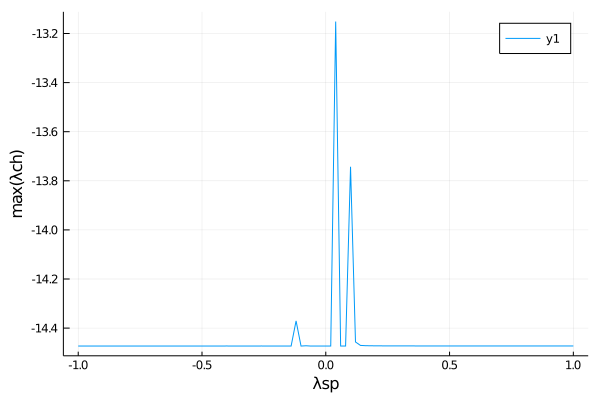

In [67]:
plot(Œªsp_range[1:end], resi[1:end], xlabel="Œªsp", ylabel="max(Œªch)")
#savefig("max_lambdach_of_lambdasp.pdf")

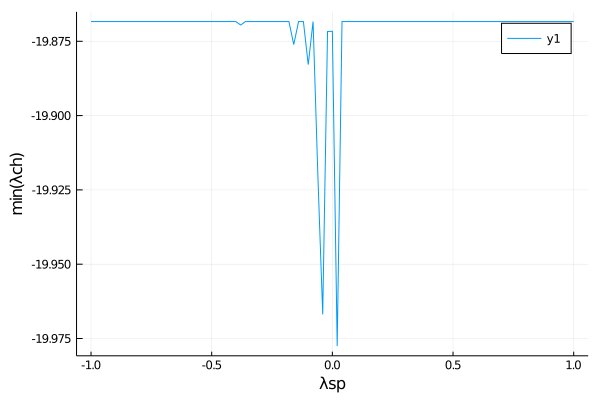

In [68]:
plot(Œªsp_range[1:end], resi2[1:end], xlabel="Œªsp", ylabel="min(Œªch)")
#savefig("min_lambdach_of_lambdasp.pdf")

In [70]:
Œªch_range2 = -0.6:0.01:0.6
Œªsp_range2 = -0.5:0.01:0.5
res2 = zeros(length(Œªch_range2), length(Œªsp_range2))
œârange = intersect(usable_ch, usable_sp)

for (i,Œªch_i) in enumerate(Œªch_range2)
    for (j,Œªsp_i) in enumerate(Œªsp_range2)
        res2[i,j] = construct_f( (Œªch_i, Œªsp_i),œách[œârange,:], œásp[œârange,:])  
    end
end

MethodError: MethodError: no method matching construct_f(::Tuple{Float64,Float64}, ::Array{Complex{Float64},2}, ::Array{Complex{Float64},2})
Closest candidates are:
  construct_f(::Any, ::Any, ::Any, !Matched::Any, !Matched::Any; rhs) at In[21]:18

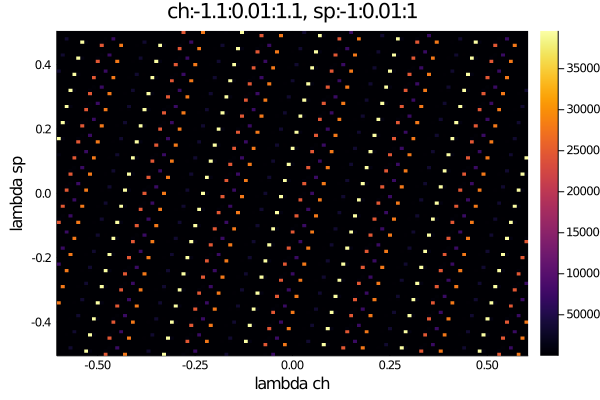

In [217]:
heatmap(Œªch_range2, Œªsp_range2, (res2 .- 0).^4, xlabel = "lambda ch", ylabel = "lambda sp", title="ch:-1.1:0.01:1.1, sp:-1:0.01:1")

In [349]:
œá_min_ch    = -minimum(1 ./ real.(œách[ceil(Int64,size(œách,1)/2),:]))
œá_min_sp    = -minimum(1 ./ real.(œásp[ceil(Int64,size(œách,1)/2),:]))
println(œá_min_ch, ", ", œá_min_sp)

-14.473154939042681, 0.09308725343569026


In [375]:
Xint = 0..1.1
fsp(Œªsp) =  construct_f(0.0, Œªsp, œách[œârange,:], œásp[œârange,:], qMultiplicity, rhs = rhs)
res_sp = IntervalRootFinding.roots(fsp, Xint, Newton, 1e-5)  
println(sort(interval.(res_sp)))
println(maximum(interval.(res_sp)))

Interval{Float64}[[0.0103389, 0.010339], [0.0143941, 0.0144021], [0.0225144, 0.0225147], [0.0236029, 0.023608], [0.0289026, 0.0289106], [0.0387014, 0.0387016], [0.049588, 0.0495966], [0.0626939, 0.062694], [0.0709535, 0.0709617], [0.0833816, 0.0833819], [0.0930821, 0.0930906], [0.0952014, 0.0952076]]
[0.0952014, 0.0952076]


In [377]:
Xint = (œá_min_ch-0.5)..(œá_min_ch+0.5)
œá_min_ch = -minimum(1 ./ real.(œách[floor(Int64,size(œách,1)/2),:]))
fch(Œªch) =  construct_f(Œªch, 0.0, œách[œârange,:], œásp[œârange,:], qMultiplicity, rhs = rhs)
res_ch = IntervalRootFinding.roots(fch, Xint)  
println(sort(interval.(res_ch)))
println(maximum(interval.(res_ch)))

Interval{Float64}[[227.512, 227.513], [227.514, 227.515]]
[227.514, 227.515]


In [333]:
Xint = -2..2
Œªch_range = -15:0.1:-14
œá_min_ch    = -minimum(1 ./ real.(œách[floor(Int64,size(œách,1)/2),:]))
res = zeros(length(Œªch_range))
for (i,Œªch_i) in enumerate(-15:0.1:-14)
    fsp_int(Œªsp) =  construct_f(Œªch_i, Œªsp, œách[œârange,:], œásp[œârange,:], qMultiplicity, rhs = rhs)
    res_sp = IntervalRootFinding.roots(fsp_int, Xint, Newton, 1e-3)
    res_sp_sort = sort(interval.(res_sp))
    println(res_sp_sort)
    res[i] = mid(maximum(interval.(res_sp)))
    println(i)
end

Interval{Float64}[[-0.656976, -0.65666], [-0.645462, -0.644907], [-0.42898, -0.427987], [-0.427988, -0.427488], [-0.415326, -0.414349], [-0.41435, -0.413358], [-0.413359, -0.412366], [-0.402512, -0.401519], [-0.40152, -0.400528], [-0.400029, -0.399521], [-0.399522, -0.398529], [-0.388839, -0.387862], [-0.387863, -0.386916], [-0.386917, -0.385955], [-0.385956, -0.384994], [-0.381105, -0.380113], [-0.380114, -0.379167], [-0.379168, -0.378205], [-0.366491, -0.365499], [-0.364493, -0.363545], [-0.363546, -0.362584], [-0.362585, -0.361623], [-0.352838, -0.351861], [-0.351862, -0.350869], [-0.348871, -0.347909], [-0.34791, -0.347508], [-0.337033, -0.336041], [-0.336042, -0.335541], [-0.330136, -0.329159], [-0.32916, -0.328198], [-0.328199, -0.327221], [-0.322341, -0.321349], [-0.32135, -0.320372], [-0.320373, -0.319381], [-0.319382, -0.318389], [-0.315446, -0.314468], [-0.314469, -0.313477], [-0.313478, -0.312501], [-0.312502, -0.311509], [-0.31151, -0.310518], [-0.307544, -0.306551], [-0.30

Interval{Float64}[[-0.617177, -0.617105], [-0.614462, -0.614187], [-0.42898, -0.427987], [-0.427988, -0.427488], [-0.415326, -0.414349], [-0.41435, -0.413358], [-0.413359, -0.412366], [-0.402512, -0.401519], [-0.40152, -0.400528], [-0.400029, -0.399521], [-0.399522, -0.398529], [-0.388839, -0.387862], [-0.387863, -0.386916], [-0.386917, -0.385955], [-0.385956, -0.384994], [-0.381105, -0.380113], [-0.380114, -0.379167], [-0.379168, -0.378205], [-0.366491, -0.365499], [-0.364493, -0.363545], [-0.363546, -0.362584], [-0.362585, -0.361623], [-0.352838, -0.351861], [-0.348871, -0.347909], [-0.34791, -0.347435], [-0.337033, -0.336041], [-0.336042, -0.335541], [-0.330136, -0.329159], [-0.32916, -0.328198], [-0.328199, -0.327221], [-0.322341, -0.321349], [-0.32135, -0.320372], [-0.320373, -0.319381], [-0.319382, -0.318389], [-0.315446, -0.314468], [-0.314469, -0.313477], [-0.313478, -0.312501], [-0.312502, -0.311509], [-0.31151, -0.310518], [-0.307544, -0.306551], [-0.305545, -0.304552], [-0.3

Interval{Float64}[[-0.615255, -0.614461], [-0.6068, -0.606756], [-0.42898, -0.427987], [-0.427988, -0.427488], [-0.415326, -0.414349], [-0.41435, -0.413358], [-0.413359, -0.412366], [-0.402512, -0.401519], [-0.40152, -0.400528], [-0.400029, -0.399521], [-0.399522, -0.398529], [-0.388839, -0.387862], [-0.387863, -0.386916], [-0.386917, -0.385955], [-0.385956, -0.384994], [-0.381105, -0.380113], [-0.380114, -0.379167], [-0.379168, -0.378205], [-0.366491, -0.365499], [-0.364493, -0.363545], [-0.363546, -0.362584], [-0.362585, -0.361623], [-0.352838, -0.351861], [-0.348871, -0.347909], [-0.347414, -0.346933], [-0.337033, -0.336041], [-0.336042, -0.335541], [-0.330136, -0.329159], [-0.32916, -0.328198], [-0.328199, -0.327221], [-0.322341, -0.321349], [-0.32135, -0.320372], [-0.320373, -0.319381], [-0.319382, -0.318389], [-0.315446, -0.314468], [-0.314469, -0.313477], [-0.313478, -0.312501], [-0.312502, -0.311509], [-0.31151, -0.310518], [-0.307544, -0.306551], [-0.305545, -0.304552], [-0.30

Interval{Float64}[[-0.668343, -0.667733], [-0.42898, -0.427987], [-0.427988, -0.427488], [-0.415326, -0.414349], [-0.41435, -0.413358], [-0.413359, -0.412366], [-0.402512, -0.401519], [-0.40152, -0.400528], [-0.400029, -0.399521], [-0.399522, -0.398529], [-0.388839, -0.387862], [-0.387863, -0.386916], [-0.386917, -0.385955], [-0.385956, -0.384994], [-0.381105, -0.380113], [-0.380114, -0.379167], [-0.379168, -0.378205], [-0.366491, -0.365499], [-0.364493, -0.363545], [-0.363546, -0.362584], [-0.362585, -0.361623], [-0.352838, -0.351861], [-0.351862, -0.350869], [-0.348871, -0.347909], [-0.34791, -0.347527], [-0.337033, -0.336041], [-0.336042, -0.335541], [-0.330136, -0.329159], [-0.32916, -0.328198], [-0.328199, -0.327221], [-0.322341, -0.321349], [-0.32135, -0.320372], [-0.320373, -0.319381], [-0.319382, -0.318389], [-0.315446, -0.314468], [-0.314469, -0.313477], [-0.313478, -0.312501], [-0.312502, -0.311509], [-0.31151, -0.310518], [-0.307544, -0.306551], [-0.305545, -0.304552], [-0.3

Interval{Float64}[[-0.709881, -0.709333], [-0.707951, -0.707624], [-0.42898, -0.427987], [-0.427988, -0.427488], [-0.415326, -0.414349], [-0.41435, -0.413358], [-0.413359, -0.412366], [-0.402512, -0.401519], [-0.40152, -0.400528], [-0.400029, -0.399521], [-0.399522, -0.398529], [-0.388839, -0.387862], [-0.387863, -0.386916], [-0.386917, -0.385955], [-0.385956, -0.384994], [-0.381105, -0.380113], [-0.380114, -0.379167], [-0.379168, -0.378205], [-0.366491, -0.365499], [-0.364493, -0.363545], [-0.363546, -0.362584], [-0.362585, -0.361623], [-0.352838, -0.351861], [-0.351862, -0.350869], [-0.348871, -0.347909], [-0.34791, -0.347586], [-0.337033, -0.336041], [-0.336042, -0.335541], [-0.330136, -0.329159], [-0.32916, -0.328198], [-0.328199, -0.327221], [-0.322341, -0.321349], [-0.32135, -0.320372], [-0.320373, -0.319381], [-0.319382, -0.318389], [-0.315446, -0.314468], [-0.314469, -0.313477], [-0.313478, -0.312501], [-0.312502, -0.311509], [-0.31151, -0.310518], [-0.307544, -0.306551], [-0.3

Interval{Float64}[[-0.738249, -0.738186], [-0.42898, -0.427987], [-0.427988, -0.427488], [-0.415326, -0.414349], [-0.41435, -0.413358], [-0.413359, -0.412366], [-0.402512, -0.401519], [-0.40152, -0.400528], [-0.400529, -0.400028], [-0.400029, -0.399521], [-0.399522, -0.398529], [-0.388839, -0.387862], [-0.387863, -0.386916], [-0.386917, -0.385955], [-0.385956, -0.384994], [-0.381105, -0.380113], [-0.380114, -0.379167], [-0.379168, -0.378205], [-0.366491, -0.365499], [-0.364493, -0.363545], [-0.363546, -0.362584], [-0.362585, -0.361623], [-0.352838, -0.351861], [-0.351862, -0.350869], [-0.348871, -0.347909], [-0.34791, -0.347621], [-0.337033, -0.336041], [-0.336042, -0.335541], [-0.330136, -0.329159], [-0.32916, -0.328198], [-0.328199, -0.327221], [-0.322341, -0.321349], [-0.32135, -0.320372], [-0.320373, -0.319381], [-0.319382, -0.318389], [-0.315446, -0.314468], [-0.314469, -0.313477], [-0.313478, -0.312501], [-0.312502, -0.311509], [-0.31151, -0.310518], [-0.307544, -0.306551], [-0.3

In [334]:
res

11-element Array{Float64,1}:
 0.09322727805996237
 0.09322727805996237
 0.09322727805996237
 0.09322727805996237
 0.09322727805996237
 0.09322727805996237
 0.09322727805996237
 0.09322727805996237
 0.09322727805996237
 0.09322727805996237
 0.09322727805996237

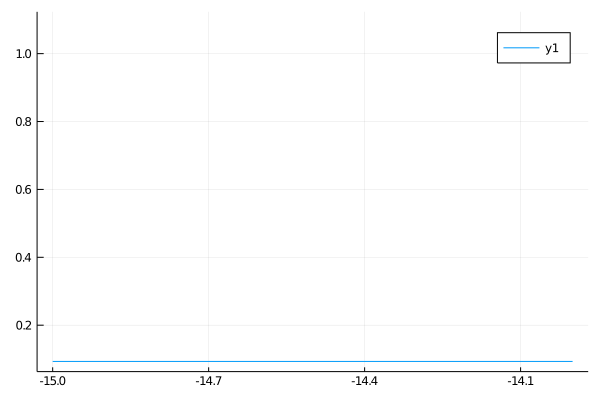

In [335]:
plot(Œªch_range, res)

In [310]:
Xint = -20..20
function f_full( (Œªch, Œªsp) ) 
    r = construct_f(Œªch, Œªsp, œách[œârange,:], œásp[œârange,:], qMultiplicity, rhs = rhs)
    return SVector(r,r)
end

function test( (Œªch, Œªsp) ) 
    r = Œªch + Œªsp
    return SVector(r,r)
end
    
res = IntervalRootFinding.roots(f_full, Xint √ó Xint, Newton, 1e-1)  
#println(sort(interval.(res)))
#println(maximum(interval.(res)))

InterruptException: InterruptException:

In [67]:
include("src/LadderDGA.jl")
include("test/loadFortranData.jl")

loadFortranData (generic function with 1 method)